In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sk
from decimal import Decimal
from sklearn import linear_model
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier as ovr
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
dr = '~/Projects/VQA_nonDL/data/'
dtype = {'BitRate': np.float64, 'FreezeRatio': np.float64, 'Quality': np.int32}
df = pd.read_table(dr + 'data.txt', delim_whitespace=True, dtype = dtype)
df['BitRate'] /= 100  # transforming BitRate to percentages

In [3]:
classifiers = {'Random Forest': RandomForestClassifier(random_state = 1), 
               'Nearest Neighbors': KNeighborsClassifier(),
               'Naive Bayers': GaussianNB(),
               'SVM': SVC(probability = True),
               'MLP': MLPClassifier(random_state = 1, max_iter = 10000),
               'AdaBoost': AdaBoostClassifier(random_state = 1)
              }

params = {'Random Forest': {'n_estimators': range(1, 21), 'criterion': ('gini', 'entropy')},
          'Nearest Neighbors': {'n_neighbors':range(1, 11)},
          'Naive Bayers': {},
          'SVM': {'kernel':('poly', 'rbf', 'sigmoid'), 'C':[0.1, 1, 10]},
          'MLP': {'hidden_layer_sizes': [(5,), (10,), (25,), (50,), (100,), (200,)], 
                  'alpha': [0.0001, 0.001],
                  'activation': ('logistic', 'tanh', 'relu'), 
                  'solver': ('lbfgs', 'sgd', 'adam')},
          'AdaBoost': {'n_estimators': [10, 25, 50, 100], 'learning_rate': [0.01, 0.1, 1, 10]}
         }

In [4]:
# get (X, y) and split to train, validation and test set
X, y = np.array(df[['BitRate', 'FreezeRatio']]), np.array(df['Quality'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3333, random_state = 1)
accuracies = {}
confusion = {}
fold = 4

In [5]:
# function for obtaining best estimator using grid search
def grid_search(X, y, estimator, params, fold):
    clf = GridSearchCV(estimator, params, cv=fold)
    clf.fit(X, y)
    return (clf.best_estimator_, clf.best_score_)

In [6]:
best_classifiers = {}
for k in classifiers.keys():
    best_classifiers[k], _ = grid_search(X_train, y_train, classifiers[k], params[k], fold)
    #accuracies[k], confusion[k] = k_Fold_CV(best_classifiers[k], fold)

In [7]:
best_classifiers

{'AdaBoost': AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
           learning_rate=0.01, n_estimators=10, random_state=1),
 'MLP': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=(5,), learning_rate='constant',
        learning_rate_init=0.001, max_iter=10000, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
        solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
        warm_start=False),
 'Naive Bayers': GaussianNB(priors=None),
 'Nearest Neighbors': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=9, p=2,
            weights='uniform'),
 'Random Forest': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min

In [8]:
# Finalizing models and evaluate performance on test set
print('Classifer Training Accuracy Test Accuracy')
for name, clf in best_classifiers.items():
    clf.fit(X_train, y_train)
    print('{} {} {}'.format(name, clf.score(X_train, y_train), clf.score(X_test, y_test)))

Classifer Training Accuracy Test Accuracy
Random Forest 0.985 0.87
Nearest Neighbors 0.905 0.83
Naive Bayers 0.875 0.92
SVM 0.865 0.88
MLP 0.89 0.86
AdaBoost 0.86 0.87


In [9]:
# binarize labels
classes = [0,1,2]
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

def plot_roc(fpr, tpr, roc_auc, clf_name, lb):
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = {0:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: {}, Class {}'.format(clf_name, lb))
    plt.legend(loc="lower right")
    plt.show()
        
def get_roc(X_tr, y_tr, X_te, y_te, clf):
    fpr = {}
    tpr = {}
    roc_auc = {}
    y_score = ovr(clf).fit(X_tr, y_tr).predict_proba(X_te)
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return (fpr, tpr, roc_auc)

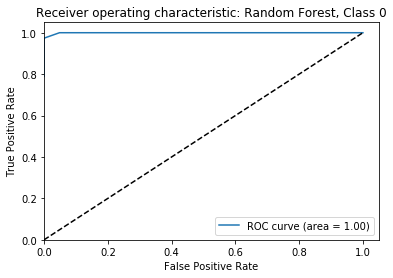

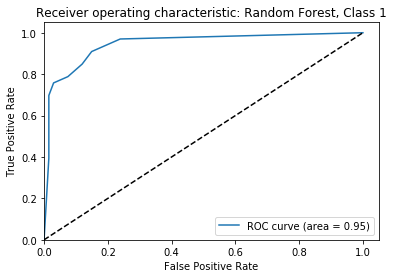

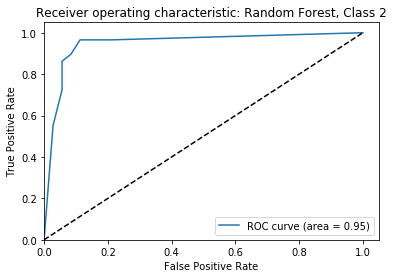

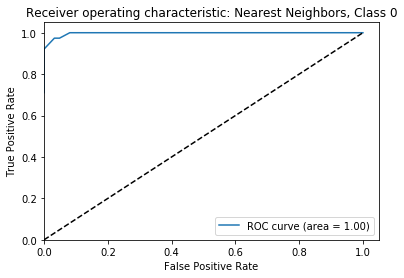

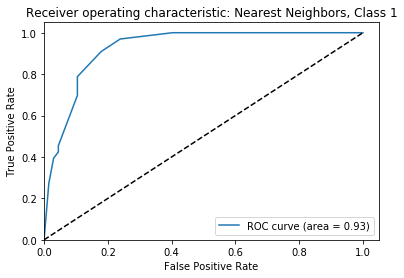

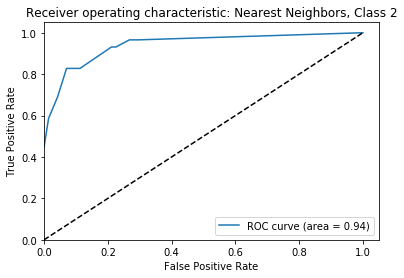

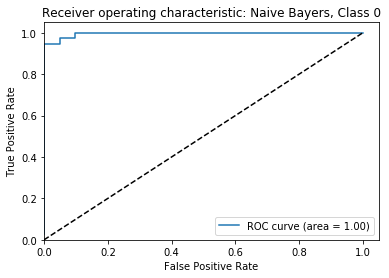

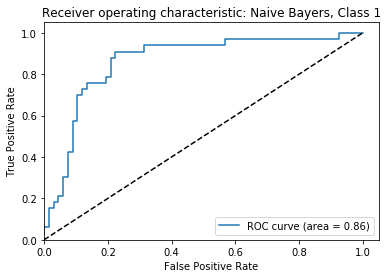

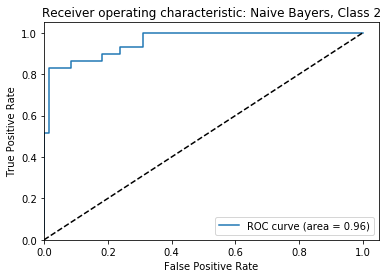

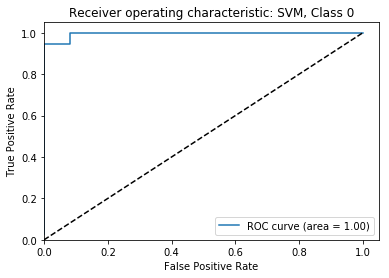

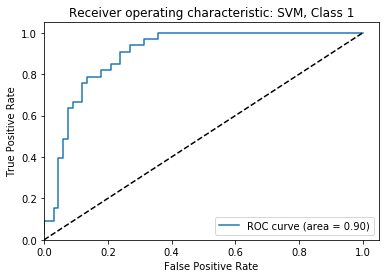

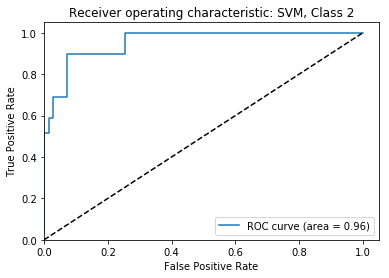

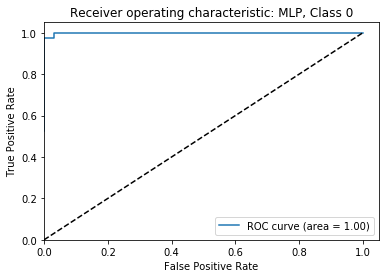

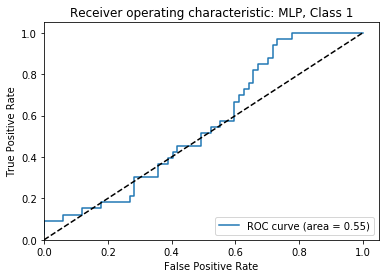

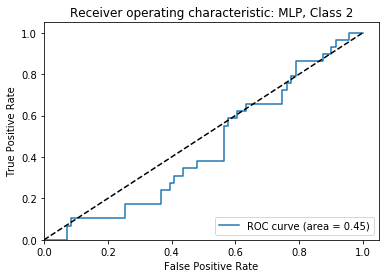

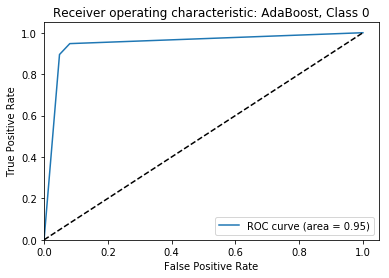

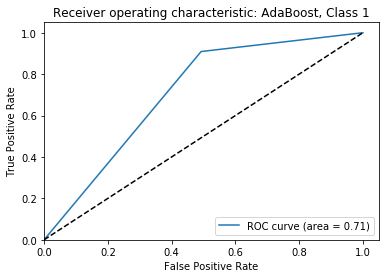

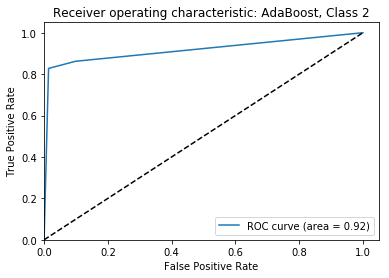

In [10]:
# ROC curves for each classifier
for k, v in best_classifiers.items():
    fpr, tpr, roc_auc = get_roc(X_train, y_train_bin, X_test, y_test_bin, v)
    for i in classes:
        plot_roc(fpr[i], tpr[i], roc_auc[i], k, i)

In [11]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(clf_name, xx, yy, **params):
    Z = best_classifiers[clf_name].predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

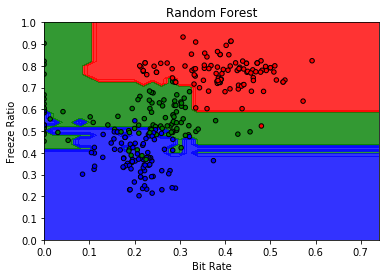

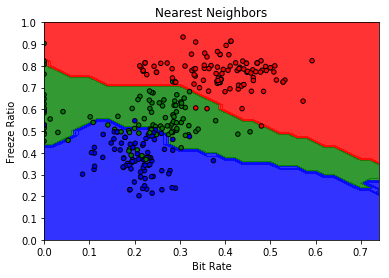

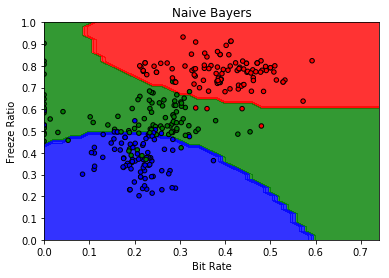

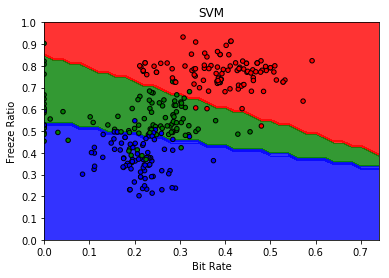

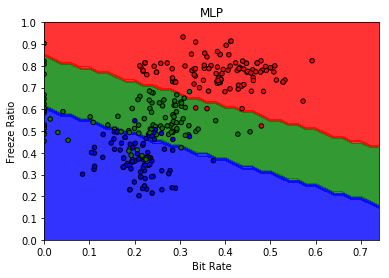

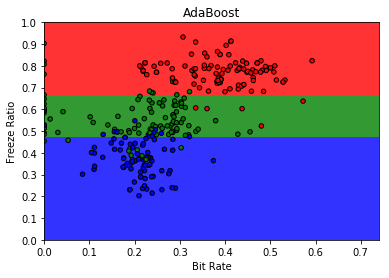

In [15]:
colors = ['red', 'green', 'blue']
cmap = mpl.colors.ListedColormap(colors)
x_rg = np.arange(0, 0.75, 0.01)
y_rg = np.arange(0, 1.01, 0.01)
x1, x2, lb = X[:,0], X[:,1], y
xx1, xx2 = make_meshgrid(rg, rg)
for clf in best_classifiers:
    plot_contours(clf, xx1, xx2, cmap=cmap, alpha=0.8)
    plt.scatter(x1, x2, c = lb, cmap=cmap, s=20, edgecolors='k')
    plt.xlim(rg.min(), rg.max())
    plt.ylim(rg.min(), rg.max())
    plt.xlabel('Bit Rate')
    plt.ylabel('Freeze Ratio')
    plt.xticks(np.arange(0, 0.75, 0.1))
    plt.yticks(np.arange(0, 1.01, 0.1))
    plt.title(clf)
    plt.show()